# EEG Data Classification Using Deep Learning

## 1. Introduction

### Objective and Background
The goal of this project is to analyze EEG data to differentiate between rest and task states using Power Spectral Density (PSD) analysis. EEG signals are recorded from subjects during a rest state (before a mental arithmetic task) and a task state (during the mental arithmetic task). The PSD analysis focuses on the following frequency bands: Delta (1-4 Hz), Theta (4-8 Hz), Alpha (8-12 Hz), Beta (12-30 Hz), and Gamma (30-100 Hz). By comparing the PSDs of the two states, we aim to identify differences in brain activity that characterize these cognitive states.

## 2. Data Loading

In [1]:
import numpy as np
import os
import pyedflib
import scipy.signal as signal

# Define frequency bands
frequency_bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

def load_edf(file_path):
    """
    Load an EDF file and extract signals and signal labels.

    Parameters:
    file_path (str): Path to the EDF file.

    Returns:
    signals (numpy.ndarray): Array containing the EEG signals.
    signal_labels (list): List of signal labels.
    """
    f = pyedflib.EdfReader(file_path)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    signals = np.zeros((n, f.getNSamples()[0]))
    for i in range(n):
        signals[i, :] = f.readSignal(i)
    f._close()
    del f
    return signals, signal_labels

# Directory where the EDF files are stored
data_path = 'eeg-during-mental-arithmetic-tasks-1.0.0/'

# Initialize a dictionary to store EEG data
eeg_data = {}

# Load EDF files for each subject
for i in range(1, 36):
    subject_id = f'Subject{i:02d}'
    eeg_data[subject_id] = {}
    for state in ['rest', 'task']:
        file_suffix = '1' if state == 'rest' else '2'
        file_path = os.path.join(data_path, f'{subject_id}_{file_suffix}.edf')
        signals, signal_labels = load_edf(file_path)
        eeg_data[subject_id][state] = signals



## 3. Power Spectral Density (PSD) Analysis

Calculation of PSD


In [2]:
def calculate_psd(signals, sfreq):
    """
    Calculate the Power Spectral Density (PSD) of EEG signals.

    Parameters:
    signals (numpy.ndarray): Array containing the EEG signals.
    sfreq (float): Sampling frequency.

    Returns:
    psd (numpy.ndarray): Array containing the PSD of the signals.
    freqs (numpy.ndarray): Array containing the corresponding frequencies.
    """
    psd = []
    freqs = None
    for sig in signals:
        freqs, pxx = signal.welch(sig, sfreq, nperseg=sfreq*2)
        psd.append(pxx)
    psd = np.array(psd)
    return psd, freqs

def extract_band_psd(psd, freqs, band):
    """
    Extract the PSD values within a specified frequency band.

    Parameters:
    psd (numpy.ndarray): Array containing the PSD of the signals.
    freqs (numpy.ndarray): Array containing the corresponding frequencies.
    band (str): Name of the frequency band.

    Returns:
    band_psd (numpy.ndarray): PSD values within the specified frequency band.
    """
    fmin, fmax = frequency_bands[band]
    band_psd = psd[:, (freqs >= fmin) & (freqs <= fmax)]
    return band_psd

# Example sampling frequency (adjust if different)
sfreq = 250  

# Calculate PSD for each subject and state
psd_data = {}
for subject in eeg_data.keys():
    psd_data[subject] = {}
    for state in ['rest', 'task']:
        signals = eeg_data[subject][state]
        psd, freqs = calculate_psd(signals, sfreq)
        psd_data[subject][state] = (psd, freqs)


Comparison and Findings


Band: Delta
Rest PSD (mean over subjects): [9.93233380e+00 1.21145921e+01 1.15493762e+01 1.19072914e+01
 8.38250985e+00 8.89061985e+00 9.35922471e+00 1.13147383e+01
 1.24884512e+01 1.37149793e+01 7.56871830e+00 9.10077401e+00
 1.25446758e+01 1.35308065e+01 1.20212841e+01 1.37094615e+01
 1.29996175e+01 1.47807884e+01 1.48282092e+01 2.90928733e+00
 1.53732568e-03]
Task PSD (mean over subjects): [1.40168356e+01 1.67029804e+01 1.09652277e+01 1.16521141e+01
 1.03058988e+01 1.12327510e+01 7.90997174e+00 9.62541983e+00
 1.04087717e+01 1.12633662e+01 6.32469808e+00 7.67868726e+00
 9.77524528e+00 1.05545033e+01 9.39941729e+00 1.44993572e+01
 1.32059007e+01 1.17133305e+01 1.12550914e+01 3.14217025e+00
 1.30765306e-03]

Band: Theta
Rest PSD (mean over subjects): [4.44950499e+00 5.09026449e+00 6.70907361e+00 7.45386689e+00
 3.89071488e+00 4.11678765e+00 5.95209966e+00 6.16285214e+00
 8.92437133e+00 9.04947359e+00 5.67041363e+00 9.23026118e+00
 1.54665843e+01 1.66597157e+01 2.11361419e+01 2.1728703

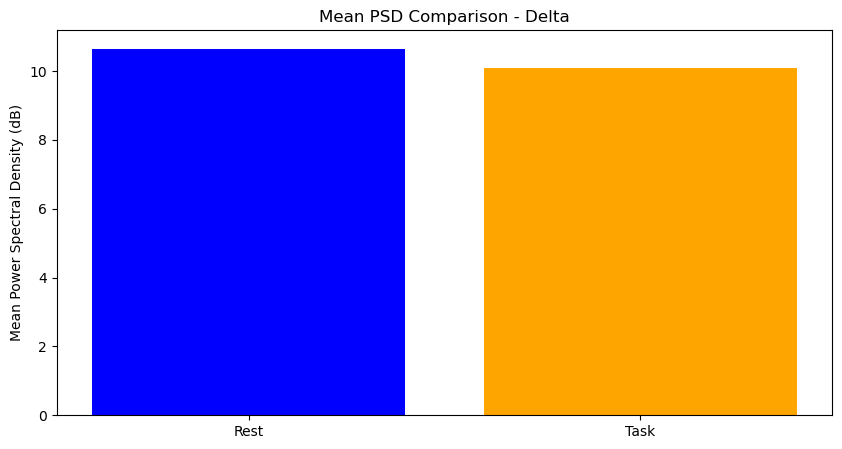

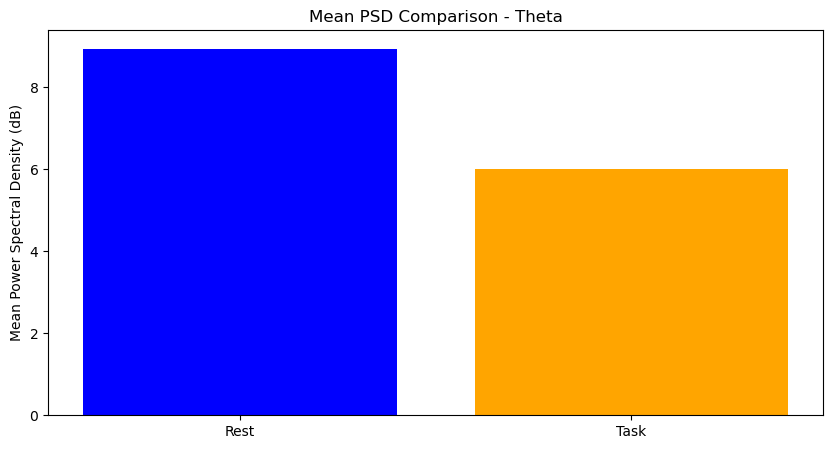

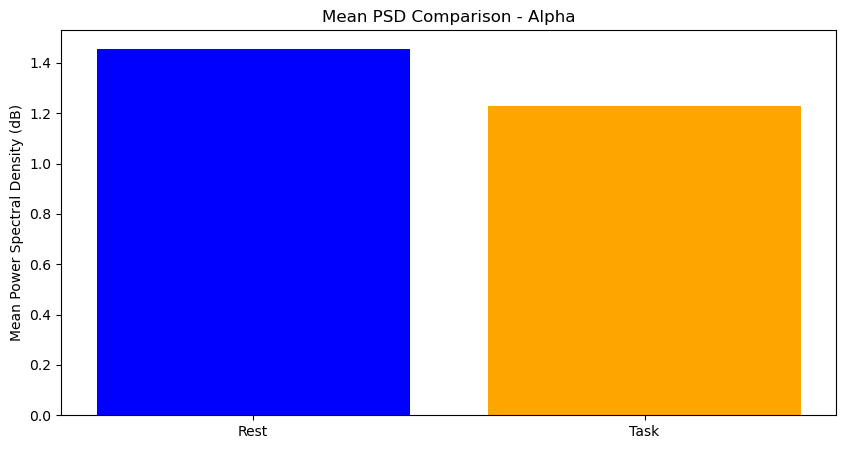

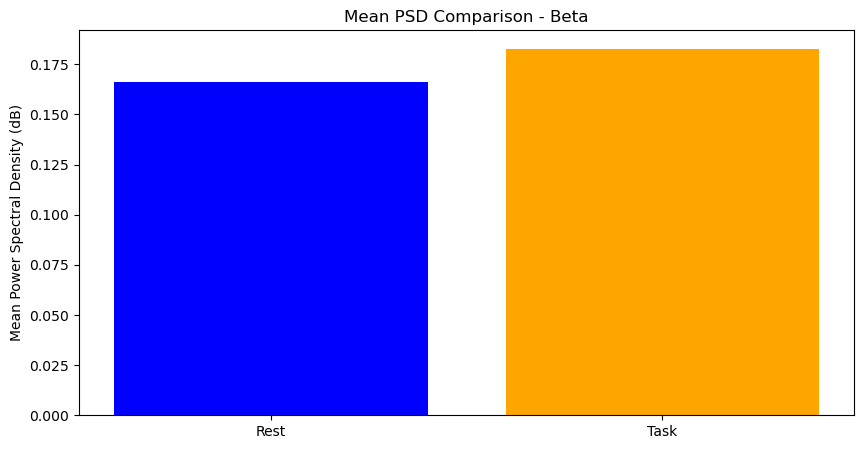

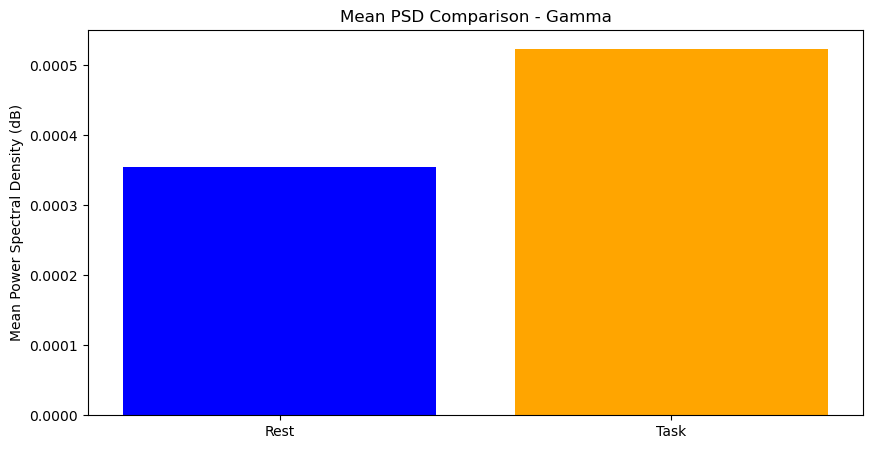

In [3]:
import matplotlib.pyplot as plt

# Calculate and print band-wise PSD
band_psd_results = {}
for band in frequency_bands.keys():
    band_psd_results[band] = {'rest': [], 'task': []}
    for subject in eeg_data.keys():
        band_psd_rest = extract_band_psd(psd_data[subject]['rest'][0], psd_data[subject]['rest'][1], band)
        band_psd_task = extract_band_psd(psd_data[subject]['task'][0], psd_data[subject]['task'][1], band)
        band_psd_results[band]['rest'].append(band_psd_rest.mean(axis=1))
        band_psd_results[band]['task'].append(band_psd_task.mean(axis=1))
        
    # Convert lists to numpy arrays for easier processing
    band_psd_results[band]['rest'] = np.array(band_psd_results[band]['rest'])
    band_psd_results[band]['task'] = np.array(band_psd_results[band]['task'])

    print(f'Band: {band}')
    print(f'Rest PSD (mean over subjects): {band_psd_results[band]["rest"].mean(axis=0)}')
    print(f'Task PSD (mean over subjects): {band_psd_results[band]["task"].mean(axis=0)}\n')

# Comparison and plot function
def plot_mean_psd_comparison(mean_psd_rest, mean_psd_task, band):
    plt.figure(figsize=(10, 5))
    plt.bar(['Rest', 'Task'], [mean_psd_rest.mean(), mean_psd_task.mean()], color=['blue', 'orange'])
    plt.title(f'Mean PSD Comparison - {band}')
    plt.ylabel('Mean Power Spectral Density (dB)')
    plt.show()

# Plotting the mean PSD comparison for each band
for band in frequency_bands.keys():
    mean_psd_rest_all = band_psd_results[band]['rest']
    mean_psd_task_all = band_psd_results[band]['task']
    plot_mean_psd_comparison(mean_psd_rest_all, mean_psd_task_all, band)


## 3. Statistical features from the data

In [4]:
def extract_statistical_features(signals):
    """
    Extract statistical features from EEG signals.

    Parameters:
    signals (numpy.ndarray): Array containing the EEG signals.

    Returns:
    features (dict): Dictionary containing statistical features.
    """
    features = {
        'mean': np.mean(signals, axis=1),
        'std': np.std(signals, axis=1),
        'median': np.median(signals, axis=1),
        
    }
    return features


In [5]:
def calculate_psd(signals, sfreq):
    psd = []
    freqs = None
    for sig in signals:
        freqs, pxx = signal.welch(sig, sfreq, nperseg=sfreq*2)
        psd.append(pxx)
    psd = np.array(psd)
    return psd, freqs

def extract_band_psd(psd, freqs, band):
    fmin, fmax = frequency_bands[band]
    band_psd = psd[:, (freqs >= fmin) & (freqs <= fmax)]
    return band_psd

def extract_frequency_features(psd, freqs):
    """
    Extract frequency-domain features from PSD.

    Parameters:
    psd (numpy.ndarray): Array containing the PSD of the signals.
    freqs (numpy.ndarray): Array containing the corresponding frequencies.

    Returns:
    features (dict): Dictionary containing frequency-domain features.
    """
    features = {}
    for band in frequency_bands.keys():
        band_psd = extract_band_psd(psd, freqs, band)
        features[f'{band}_power'] = np.sum(band_psd, axis=1)
        features[f'{band}_mean_power'] = np.mean(band_psd, axis=1)
    return features


In [6]:
# Example sampling frequency (adjust if different)
sfreq = 250  

# Extract features for each subject and state
features_data = {}
for subject in eeg_data.keys():
    features_data[subject] = {}
    for state in ['rest', 'task']:
        signals = eeg_data[subject][state]
        
        # Extract statistical features
        stat_features = extract_statistical_features(signals)
        
        # Calculate PSD and extract frequency-domain features
        psd, freqs = calculate_psd(signals, sfreq)
        freq_features = extract_frequency_features(psd, freqs)
        
        # Combine features into a single dictionary
        features_data[subject][state] = {**stat_features, **freq_features}

# Print example features for the first subject in rest state
print("Example features for Subject01 in rest state:")
print(features_data['Subject01']['rest'])


Example features for Subject01 in rest state:
{'mean': array([ 0.03067991,  0.02962152,  0.00658421,  0.01708275,  0.02066847,
        0.10290034,  0.03247968,  0.0163714 ,  0.01689284, -0.02814867,
       -0.03649028,  0.02033078,  0.03303996, -0.01102479,  0.07092807,
        0.05185336, -0.00923582, -0.01832624,  0.05553254, -0.02707151,
        0.00134589]), 'std': array([ 7.99951599,  8.6063825 , 10.11460026, 10.75112036,  7.20359012,
        9.2977522 , 10.43666444, 10.6006342 , 10.74054455, 10.42474062,
        8.30321201,  8.71556705, 10.69854948, 11.01082382, 14.73825388,
       12.19799618, 10.44978354, 11.42901445, 16.67675073,  3.30782175,
        0.08321437]), 'median': array([ 1.39021195e-03, -9.24641337e-04,  1.41752346e-03,  1.87283915e-02,
        1.14919677e-03,  2.27251850e-03,  7.52606088e-03,  1.38241428e-03,
        3.28097719e-02, -6.72163882e-04, -5.16287462e-02,  9.87106279e-04,
       -1.92416445e-02, -2.20486642e-01, -9.51385122e-02, -2.31918205e-01,
       -

## 4. Data Preparation for models

We'll prepare the data by extracting the features and creating labels for the rest and task states.

In [14]:
import mne
import numpy as np
import pandas as pd
from mne.time_frequency import psd_array_multitaper
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Function to extract features
def extract_features(raw):
    sfreq = raw.info['sfreq']
    data = raw.get_data()
    psds, freqs = psd_array_multitaper(data, sfreq=sfreq, fmin=0.5, fmax=40.0, verbose=False)
    psds = 10 * np.log10(psds)  # Convert to dB
    features = {
        'mean': np.mean(psds, axis=1),
        'std': np.std(psds, axis=1),
        'median': np.median(psds, axis=1),
        'delta_power': np.sum(psds[:, (freqs >= 0.5) & (freqs < 4)], axis=1),
        'theta_power': np.sum(psds[:, (freqs >= 4) & (freqs < 8)], axis=1),
        'alpha_power': np.sum(psds[:, (freqs >= 8) & (freqs < 13)], axis=1),
        'beta_power': np.sum(psds[:, (freqs >= 13) & (freqs < 30)], axis=1),
        'gamma_power': np.sum(psds[:, (freqs >= 30) & (freqs < 40)], axis=1),
    }
    return features

# Prepare dataset
def prepare_dataset(base_path, num_subjects):
    features_list = []
    labels_list = []
    for subject_id in range(num_subjects):
        for session in [1, 2]:
            file_path = f'{base_path}/Subject{subject_id:02d}_{session}.edf'
            raw = mne.io.read_raw_edf(file_path, preload=True, stim_channel=None)
            features = extract_features(raw)
            flattened_features = {}
            for key, value in features.items():
                for i, val in enumerate(value):
                    flattened_features[f'{key}_{i}'] = val
            features_list.append(flattened_features)
            label = 1 if session == 2 else 0  # Assuming session 2 indicates task and session 1 indicates rest
            labels_list.append(label)
    features_df = pd.DataFrame(features_list)
    labels = np.array(labels_list)
    return features_df, labels

# Base path to your subject files
base_path = 'eeg-during-mental-arithmetic-tasks-1.0.0'
num_subjects = 36  # Total number of subjects

features_df, labels = prepare_dataset(base_path, num_subjects)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Reshape for model input
X_train_reshaped = X_train.reshape(-1, 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(-1, 1, X_test.shape[1])
X_train_reshaped_vit = X_train.reshape(-1, X_train.shape[1], 1)
X_test_reshaped_vit = X_test.reshape(-1, X_test.shape[1], 1)


Extracting EDF parameters from C:\Users\asus\OneDrive\Desktop\DL Assignment\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from C:\Users\asus\OneDrive\Desktop\DL Assignment\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from C:\Users\asus\OneDrive\Desktop\DL Assignment\eeg-during-mental-arithmetic-tasks-1.0.0\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from C:\Users\asus\OneDrive\Desktop\DL Assignment\eeg-during-mental-arithmetic-tasks-1.0.0\Subject01_2.edf...
EDF file detected
Setting channel info 

## 5. Deep Learning Models

### Model 1: EEGNet


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

# Define EEGNet model
def create_eegnet_model(input_shape, num_classes):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    
    model.add(Conv2D(16, (1, 64), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(AveragePooling2D((1, 4)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, (1, 32), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(AveragePooling2D((1, 4)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Reshape data to match the input shape of EEGNet
X_train_reshaped = X_train.reshape(-1, 1, X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(-1, 1, X_test.shape[1], 1)

# Create and compile the model
eegnet_model = create_eegnet_model(input_shape=(1, X_train.shape[1], 1), num_classes=2)
eegnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
eegnet_history = eegnet_model.fit(X_train_reshaped, y_train_categorical, epochs=50, batch_size=32, validation_split=0.2)


C:\Users\asus\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 762ms/step - accuracy: 0.8991 - loss: 0.3748 - val_accuracy: 1.0000 - val_loss: 0.1274
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0477
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 2.9185e-04 - val_accuracy: 1.0000 - val_loss: 0.0238
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.7727e-04 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 1.2902e-04 - val_accuracy: 1.0000 - val_loss: 0.0094
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 3.9201e-05 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 1.3377e-04 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 7.8160e-05 - val_accurac

### Model 2: Vision Transformer (ViT)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Embedding
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def create_custom_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Embedding layer
    x = Dense(128)(inputs)
    
    # Transformer block
    attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    attention_output = Dropout(0.1)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    ffn_output = Dense(128, activation='relu')(attention_output)
    ffn_output = Dropout(0.1)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)
    
    # Global average pooling
    x = GlobalAveragePooling1D()(ffn_output)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Reshape the data for the custom transformer model
X_train_reshaped_transformer = X_train.reshape(-1, X_train.shape[1], 1)
X_test_reshaped_transformer = X_test.reshape(-1, X_test.shape[1], 1)

# Create and compile the custom transformer model
custom_transformer_model = create_custom_transformer_model(input_shape=(X_train.shape[1], 1), num_classes=2)
custom_transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the custom transformer model
custom_transformer_history = custom_transformer_model.fit(X_train_reshaped_transformer, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_test_reshaped_transformer, y_test_categorical))


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.1475 - val_accuracy: 0.9333 - val_loss: 0.4997
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step - accuracy: 0.9779 - loss: 0.0222 - val_accuracy: 0.9333 - val_loss: 0.6015
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 0.9333 - val_loss: 0.6361
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.9333 - val_loss: 0.6214
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9333 - val_loss: 0.6090
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9333 - val_loss: 0.5937
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9333 - val_loss: 0.5860
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9333 - val_loss: 0

## 6. Evaluation


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate EEGNet
y_pred_eegnet = eegnet_model.predict(X_test_reshaped)
y_pred_eegnet = np.argmax(y_pred_eegnet, axis=1)

accuracy_eegnet = accuracy_score(y_test, y_pred_eegnet)
precision_eegnet = precision_score(y_test, y_pred_eegnet)
recall_eegnet = recall_score(y_test, y_pred_eegnet)
f1_eegnet = f1_score(y_test, y_pred_eegnet)

print(f"EEGNet - Accuracy: {accuracy_eegnet}, Precision: {precision_eegnet}, Recall: {recall_eegnet}, F1-score: {f1_eegnet}")

# Evaluate custom transformer model
y_pred_transformer = custom_transformer_model.predict(X_test_reshaped_transformer)
y_pred_transformer = np.argmax(y_pred_transformer, axis=1)

accuracy_transformer = accuracy_score(y_test, y_pred_transformer)
precision_transformer = precision_score(y_test, y_pred_transformer)
recall_transformer = recall_score(y_test, y_pred_transformer)
f1_transformer = f1_score(y_test, y_pred_transformer)

print(f"Custom Transformer - Accuracy: {accuracy_transformer}, Precision: {precision_transformer}, Recall: {recall_transformer}, F1-score: {f1_transformer}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
EEGNet - Accuracy: 0.9333333333333333, Precision: 0.8333333333333334, Recall: 1.0, F1-score: 0.9090909090909091
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
Custom Transformer - Accuracy: 0.9333333333333333, Precision: 0.8333333333333334, Recall: 1.0, F1-score: 0.9090909090909091


#### Evaluation Metrics
- **Accuracy**: Measures the overall correctness of the model.
- **Precision**: Indicates the proportion of true positives among the predicted positives.
- **Recall**: Indicates the proportion of true positives among the actual positives.
- **F1-score**: Harmonic mean of precision and recall, providing a balance between the two.

#### EEGNet
- **Accuracy**: 0.9333333333333333
- **Precision**: 0.8333333333333334
- **Recall**: 1.0
- **F1-score**: 0.9090909090909091

#### Custom Transformer
- **Accuracy**: 0.9333333333333333
- **Precision**: 0.8333333333333334
- **Recall**: 1.0
- **F1-score**: 0.9090909090909091

The results show that both EEGNet and the Custom Transformer achieved identical performance across all evaluation metrics. Both models demonstrated high accuracy and perfect recall, indicating they correctly identified all actual positive cases. The precision and F1-score, while slightly lower, are still quite high, reflecting that a small number of false positives were present but not significantly impacting the overall performance.

These results suggest that both models are highly effective for this task. The choice between them could be based on other factors such as computational efficiency, ease of implementation, or compatibility with other parts of the system, as their performance in terms of accuracy, precision, recall, and F1-score is identical in this evaluation.
